## <center> *Модель прогнозирования стоимости жилья для агентства недвижимости*

# <center> **Часть II. Разведывательный анализ и моделирование.**

Импорт библиотек

In [1]:
import pandas as pd
import numpy as np

import scipy.stats as sps

import matplotlib.pyplot as plt
import seaborn as sns

import sklearn.preprocessing as pp 
import sklearn.model_selection as ms 
import sklearn.feature_selection as fs

import sklearn.linear_model as lm
import sklearn.tree as tree
import sklearn.ensemble as ens
import sklearn.metrics as m

import lightgbm as lgbm
import xgboost as xgb
import catboost as cb 


from functions import *

import warnings
warnings.filterwarnings('ignore')

plt.style.use('bmh')

R = 7

## **Данные**

Читаем данные

In [2]:
data = pd.read_csv('data/data_edited.csv')

data

,status for sale,status coming soon,status new,status foreclosure,status pre-foreclosure,status pending,status auction,status active,status show,status for rent,...,school distance mean,school rating nearest,school distance to best,schools with k,schools with pk,schools with preschool,school grades,target per month,target plus,target
0,0,0,0,0,0,0,0,1,0,0,...,5.537500,7,5.10,3,2,0,13,0,0,418.000
1,1,0,0,0,0,0,0,0,0,0,...,1.326667,4,1.65,1,1,0,13,0,0,310.000
2,1,0,0,0,0,0,0,0,0,0,...,1.960000,8,1.19,1,0,0,13,0,0,2895.000
3,1,0,0,0,0,0,0,0,0,0,...,0.752500,9,1.05,1,1,0,13,0,0,2395.000
4,1,0,0,0,0,0,0,0,0,0,...,4.080000,4,3.25,1,1,0,13,0,0,5.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360187,1,0,0,0,0,0,0,0,0,0,...,0.250000,3,0.40,1,1,0,13,0,0,799.000
360188,0,0,0,0,0,0,0,0,0,0,...,16.600000,10,32.10,1,1,0,13,0,0,1249.000
360189,1,0,0,0,0,0,0,0,0,0,...,4.143333,1,0.40,1,1,0,13,0,0,674.999
360190,1,0,0,0,0,0,0,0,0,0,...,0.605000,4,0.48,1,1,0,9,0,0,528.000


In [3]:
get_data_info(data)

,Nulls,Uniques,Dtypes
status for sale,0.0,2,int64
status coming soon,0.0,2,int64
status new,0.0,2,int64
status foreclosure,0.0,2,int64
status pre-foreclosure,0.0,2,int64
...,...,...,...
schools with preschool,0.0,11,int64
school grades,0.0,13,int64
target per month,0.0,2,int64
target plus,0.0,2,int64


## **Разведывательный анализ**

### Исследование бинарных переменных

In [4]:
bin_cols = set()
num_cols = []

for col in data.columns:
    if ('target' not in col) and (data[col].nunique() == 2):
        bin_cols.add(col.split()[0])
    else:
        num_cols.append(col)

bin_cols, num_cols

({'cooling', 'heating', 'parking', 'propertyType', 'status'},
 ['baths',
  'beds',
  'sqft area',
  'property age',
  'property remodeled',
  'p. spaces',
  'lotsize',
  'zipcode national area',
  'zipcode sectional center',
  'zipcode delivery area',
  'city importance',
  'city population rank',
  'school rating sum',
  'school rating mean',
  'school distance nearest',
  'school distance mean',
  'school rating nearest',
  'school distance to best',
  'schools with k',
  'schools with pk',
  'schools with preschool',
  'school grades',
  'target per month',
  'target plus',
  'target'])

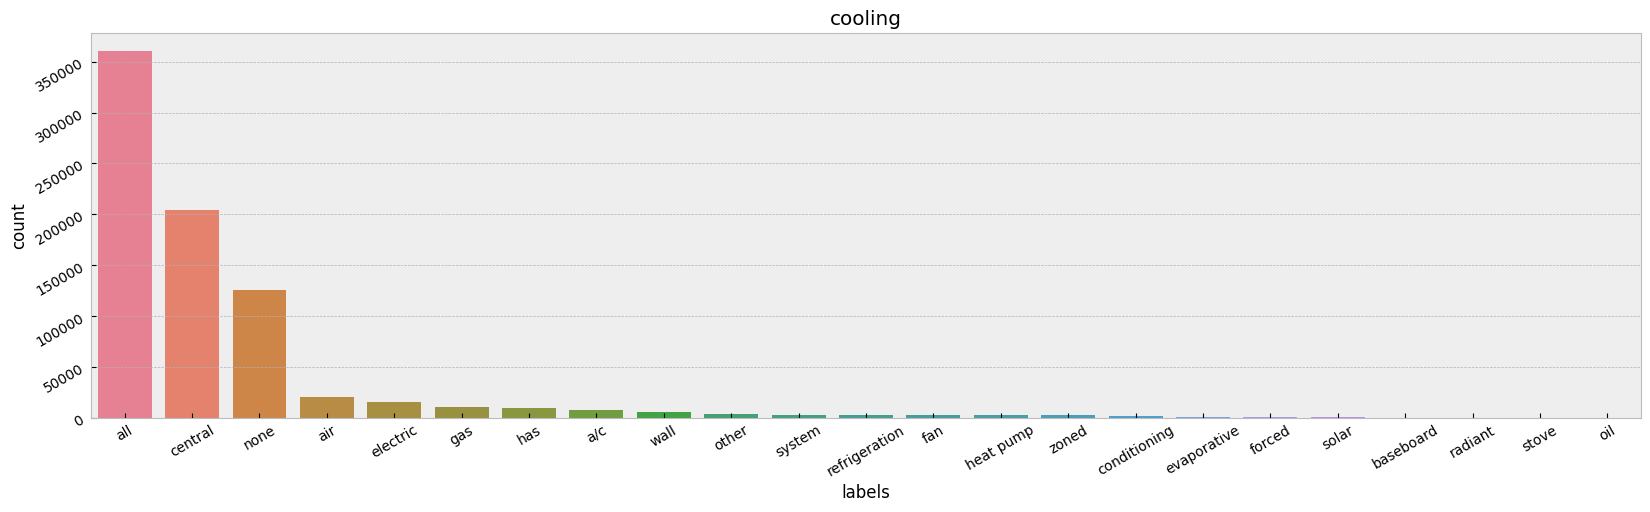

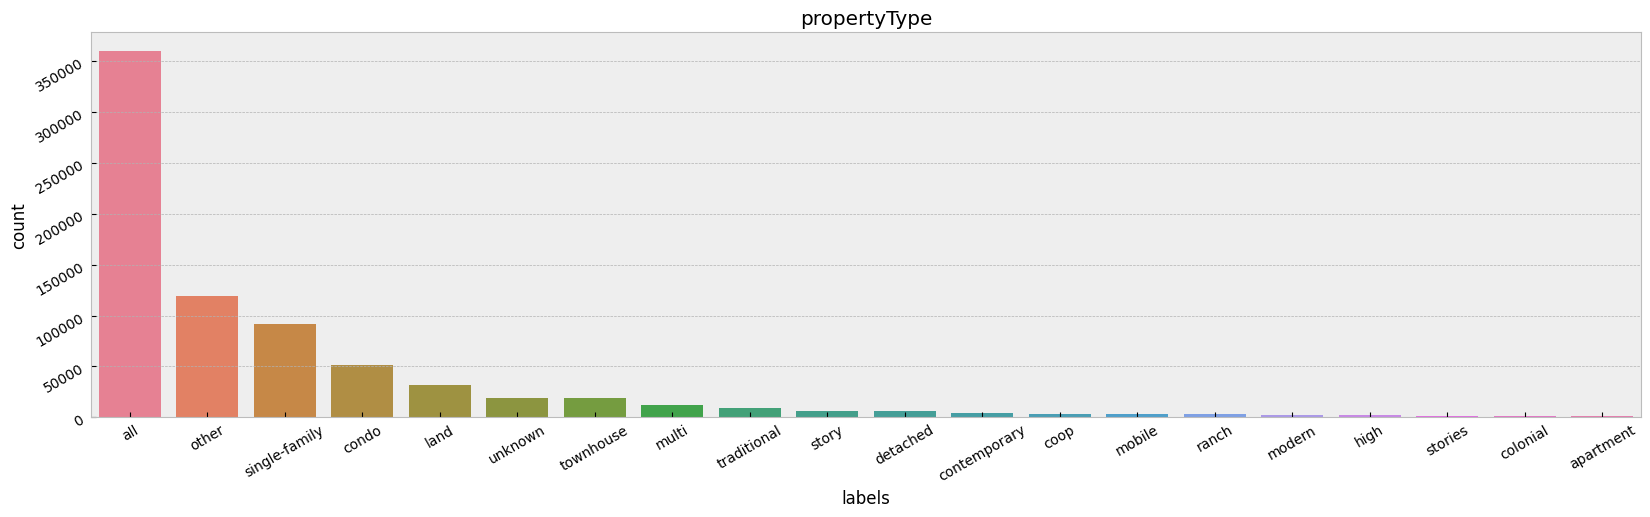

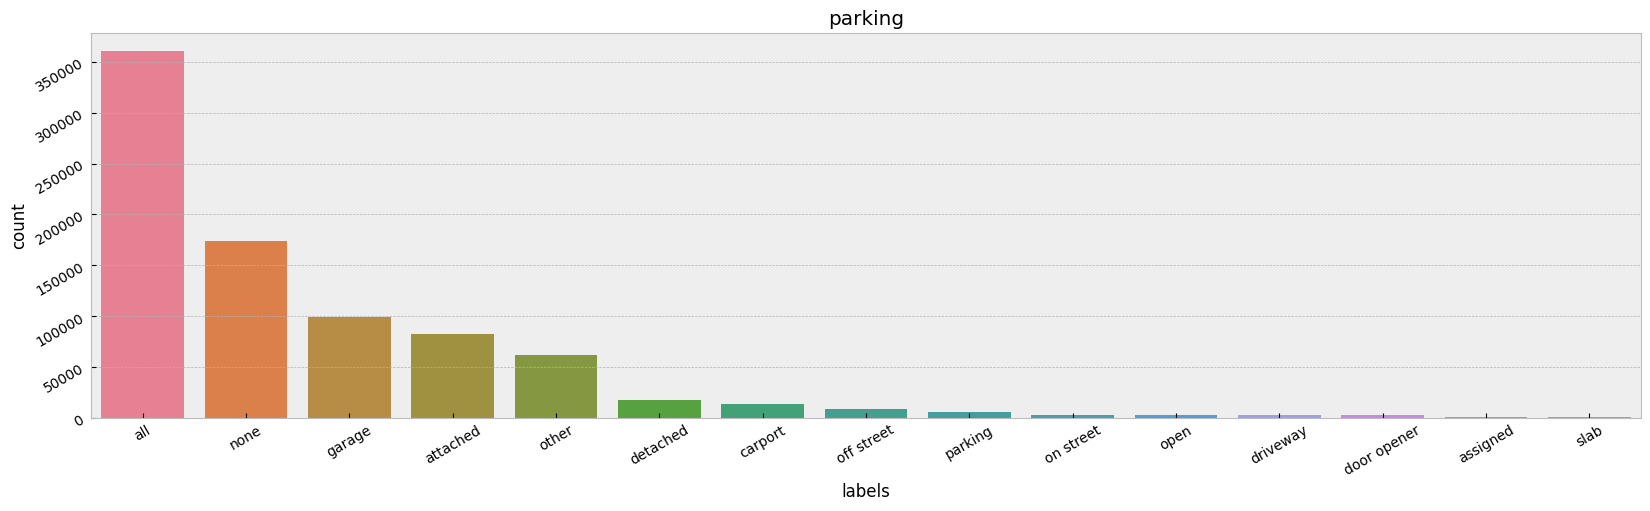

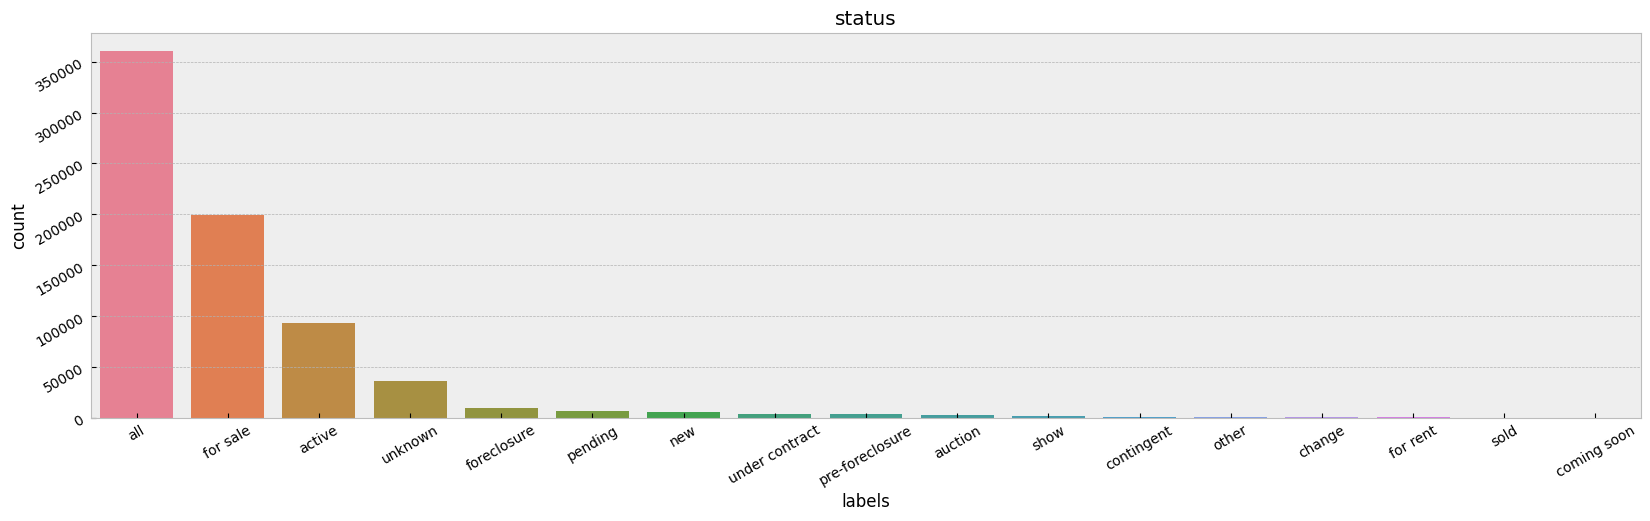

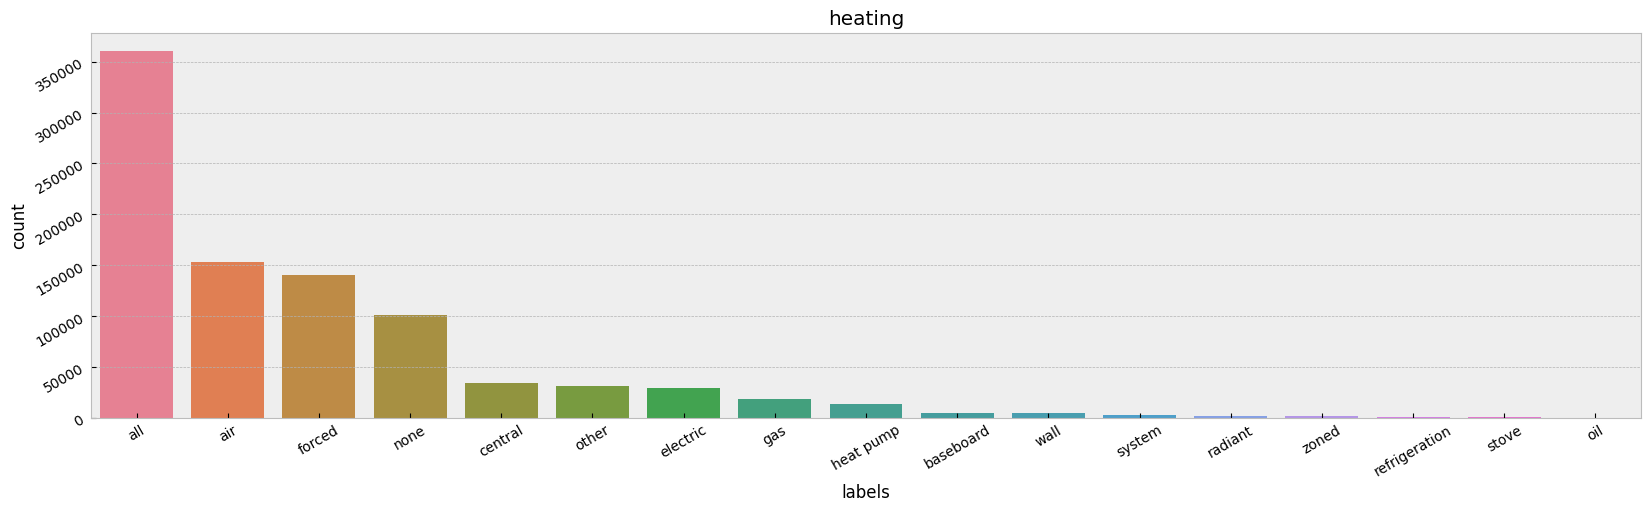

In [5]:
def show_barplot(cols, data=data, figsize=(20, 5)):
    sums = get_sums(data, cols).sort_values(ascending=False)

    col_list = sums.index.tolist() + ['all']
    vls_list = sums.values.tolist() + [data.shape[0]]

    for i in range(len(col_list)):
        col_list[i] = col_list[i].replace(cols+' ', '')

    df = (pd.DataFrame({'labels': col_list, 
                        'count': vls_list})
          .sort_values('count', ascending=False))
    
    fig, ax = plt.subplots(figsize=figsize)
    sns.barplot(df, x='labels', y='count', hue='labels', ax=ax)
    ax.tick_params(rotation=30)
    ax.set_title(cols)
    
    return fig 


for col in bin_cols:
    show_barplot(col).show()

### Проверка на нормальность

In [6]:
def test_normality(labels, 
                   data=data, 
                   testfunc='shapiro', 
                   alpha=0.05):
    
    norm_df = pd.DataFrame(index=labels)
    
    pv_list = []
    for col in data[labels].columns:
        x = data[col]
        
        if testfunc == 'dagostino':
            p = sps.normaltest(x)
            pv = round(p.pvalue[0], 3)
            alpha = alpha / 2

        p = sps.shapiro(x)
        pv = round(p.pvalue, 3)
        
        pv_list.append(pv)
    
    norm_df['p_value'] = pv_list
    norm_df['is_normal'] = norm_df['p_value'].apply(lambda pv: 'normal' if pv > alpha else 'not normal')

    return norm_df

In [7]:
test_normality(num_cols)

,p_value,is_normal
baths,0.0,not normal
beds,0.0,not normal
sqft area,0.0,not normal
property age,0.0,not normal
property remodeled,0.0,not normal
p. spaces,0.0,not normal
lotsize,1.0,normal
zipcode national area,0.0,not normal
zipcode sectional center,0.0,not normal
zipcode delivery area,0.0,not normal


### Выявление и очистка выбросов 

In [8]:
def fix_data(feature, data=data, figsize=(20, 7)):
    fig, ax = plt.subplots(3, 2, figsize=figsize)
    
    
    x = data[feature]
    
    sns.boxplot(x=x, fill=False, ax=ax[0, 0])
    ax[0, 0].set_xlabel('')
    ax[0, 0].set_ylabel('box')
    ax[0, 0].set_title(feature+' original')

    sns.histplot(x=x, bins=x.nunique(), ax=ax[1, 0])
    ax[1, 0].set_xlabel('')
    ax[1, 0].set_ylabel('hist')
    
    sns.kdeplot(x=x, ax=ax[2, 0])
    ax[2, 0].set_xlabel('')
    ax[2, 0].set_ylabel('kde')


    lim = x.quantile(0.99)
    fixed = data[x <= lim][x >= -lim].reset_index(drop=True)
    
    xnew = fixed[feature]
    
    sns.boxplot(x=xnew, fill=False, ax=ax[0, 1])
    ax[0, 1].set_xlabel('')
    ax[0, 1].set_ylabel('box')
    ax[0, 1].set_title(feature+' fixed')
    
    sns.histplot(x=xnew, bins=xnew.nunique(), ax=ax[1, 1])
    ax[1, 1].set_xlabel('')
    ax[1, 1].set_ylabel('hist')
    
    sns.kdeplot(x=xnew, ax=ax[2, 1])
    ax[2, 1].set_xlabel('')
    ax[2, 1].set_ylabel('kde')
    
    fig.show()
    print(f'{fixed.shape[0]} rows X {fixed.shape[1]} cols')
    
    return fixed

357192 rows X 112 cols


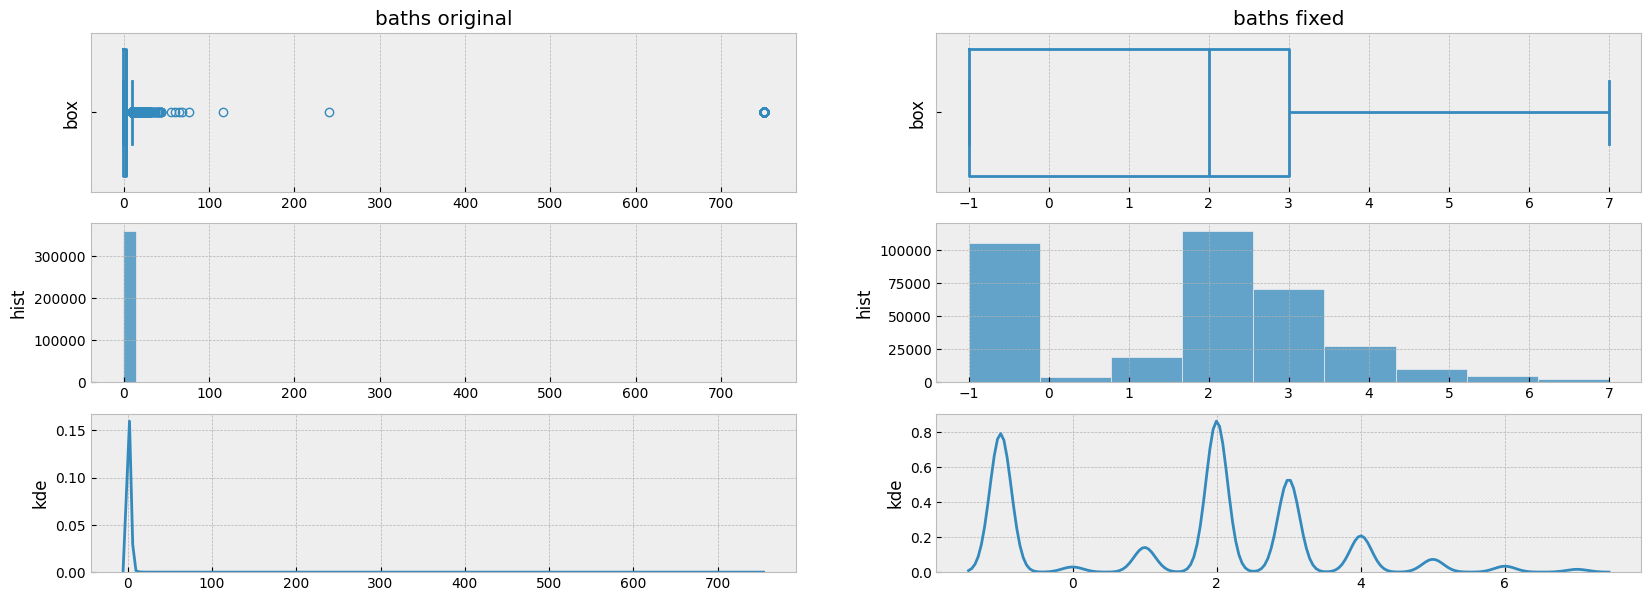

In [9]:
fixed_data = fix_data('baths')

353996 rows X 112 cols


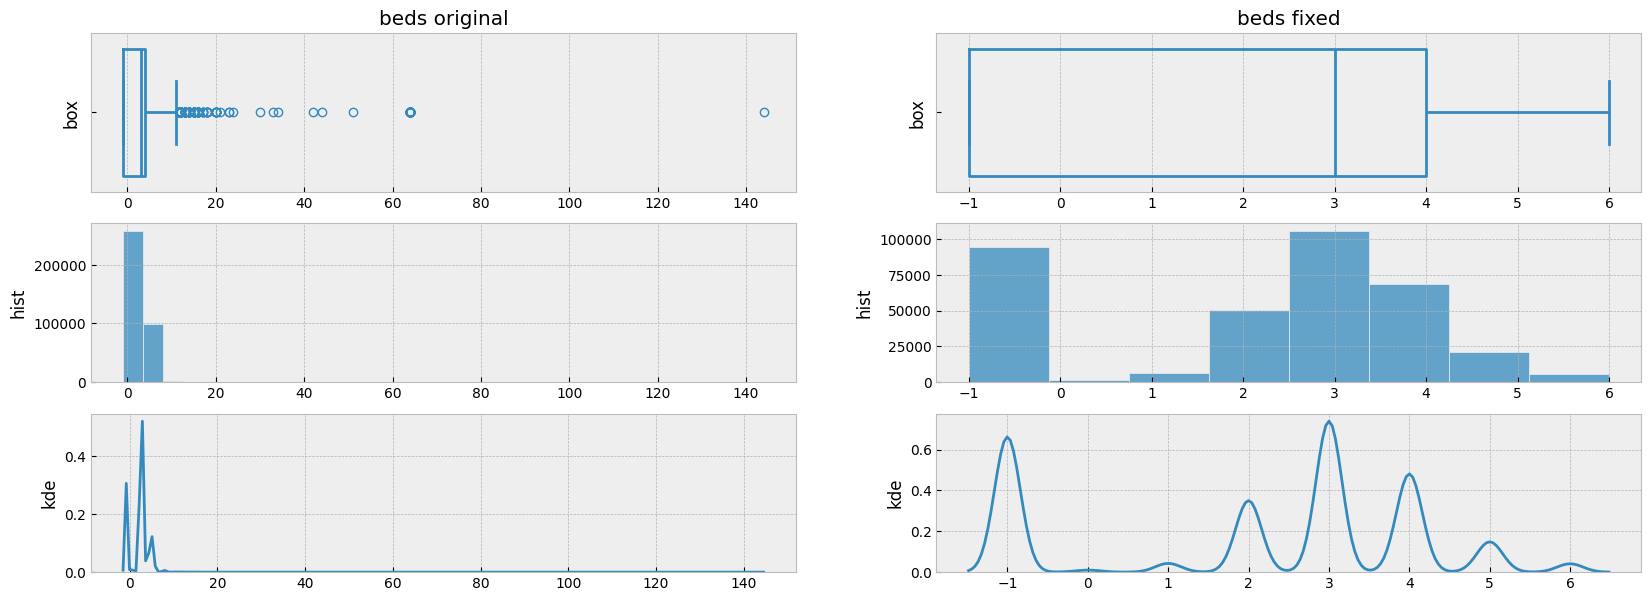

In [10]:
fixed_data = fix_data('beds', data=fixed_data)

350456 rows X 112 cols


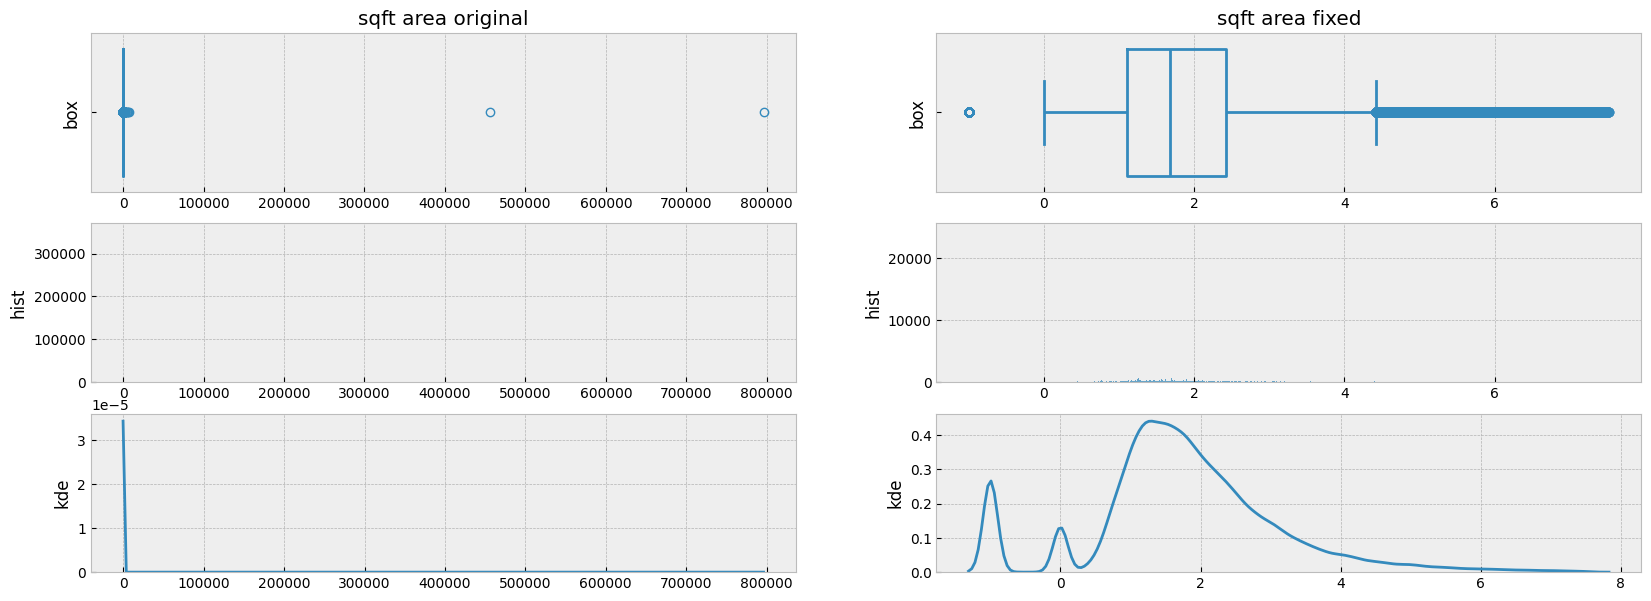

In [11]:
fixed_data = fix_data('sqft area', data=fixed_data) 

347098 rows X 112 cols


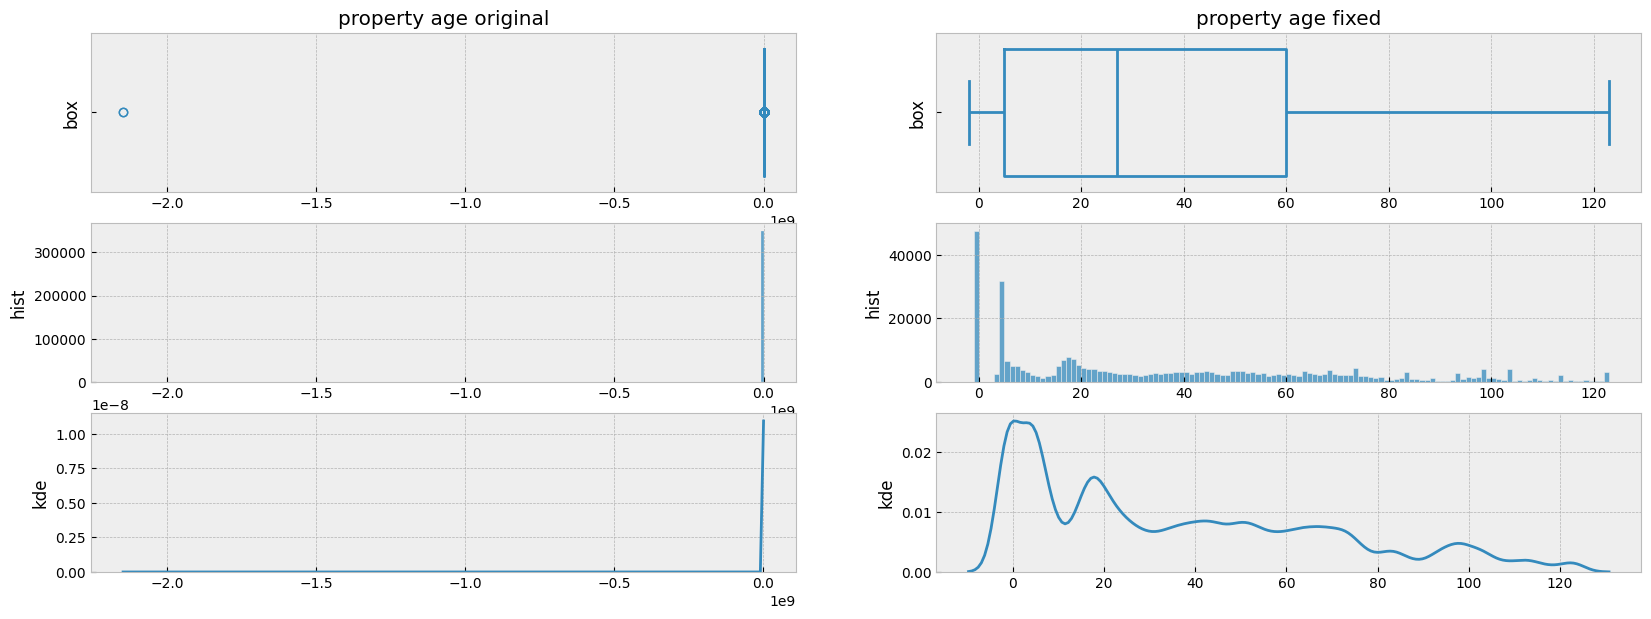

In [12]:
fixed_data = fix_data('property age', data=fixed_data)

343702 rows X 112 cols


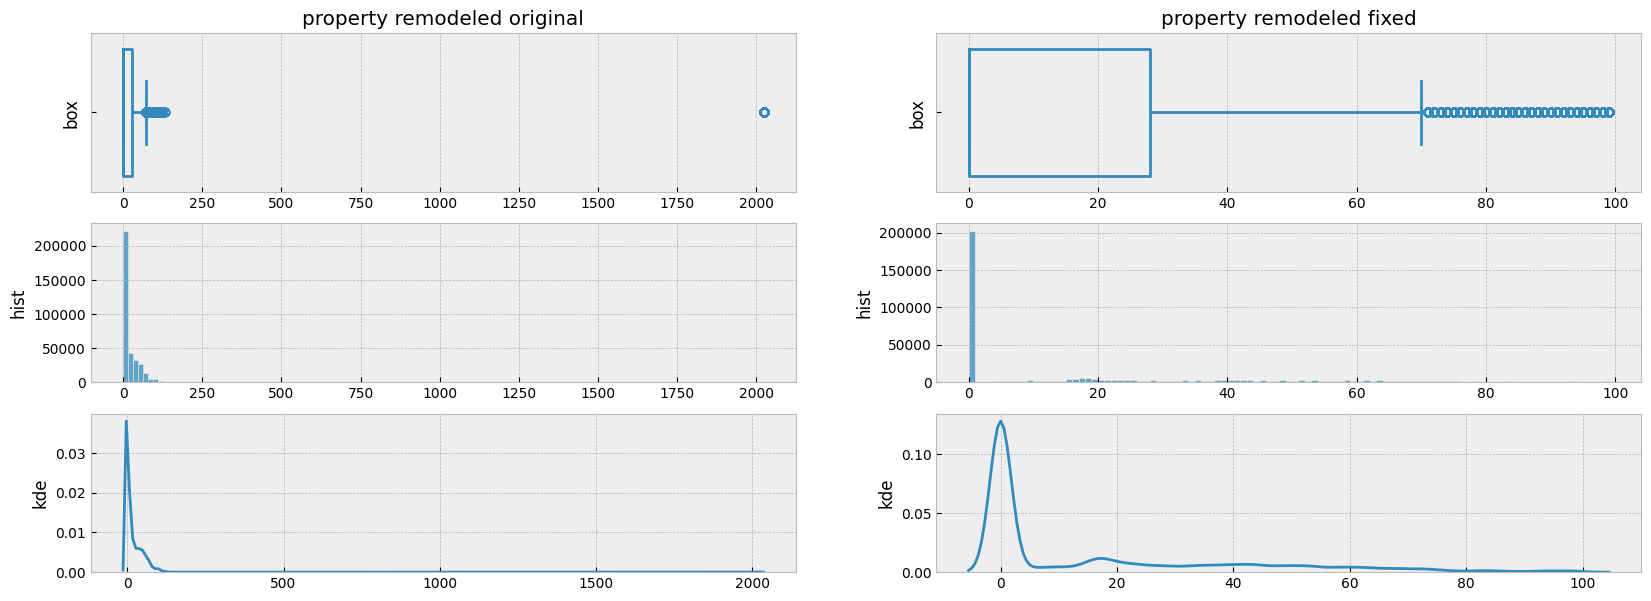

In [13]:
fixed_data = fix_data('property remodeled', data=fixed_data) 

341530 rows X 112 cols


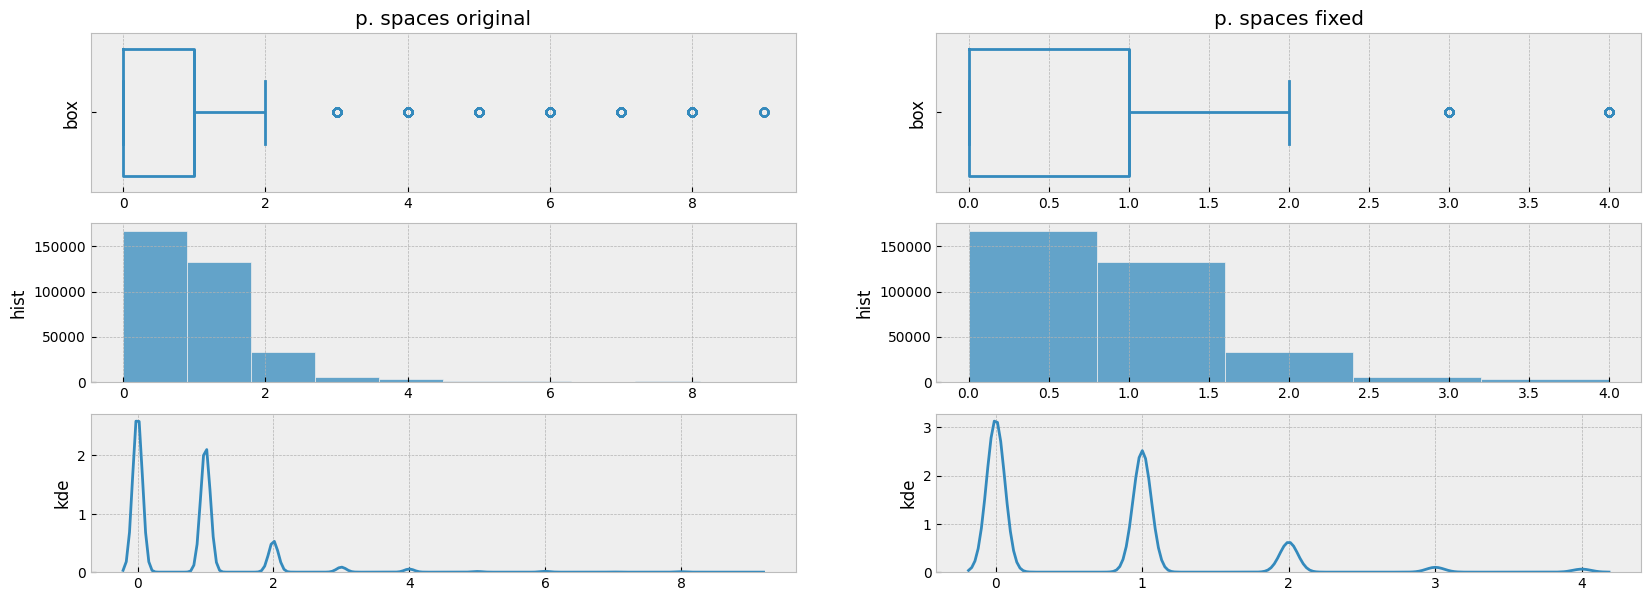

In [14]:
fixed_data = fix_data('p. spaces', data=fixed_data)

336917 rows X 112 cols


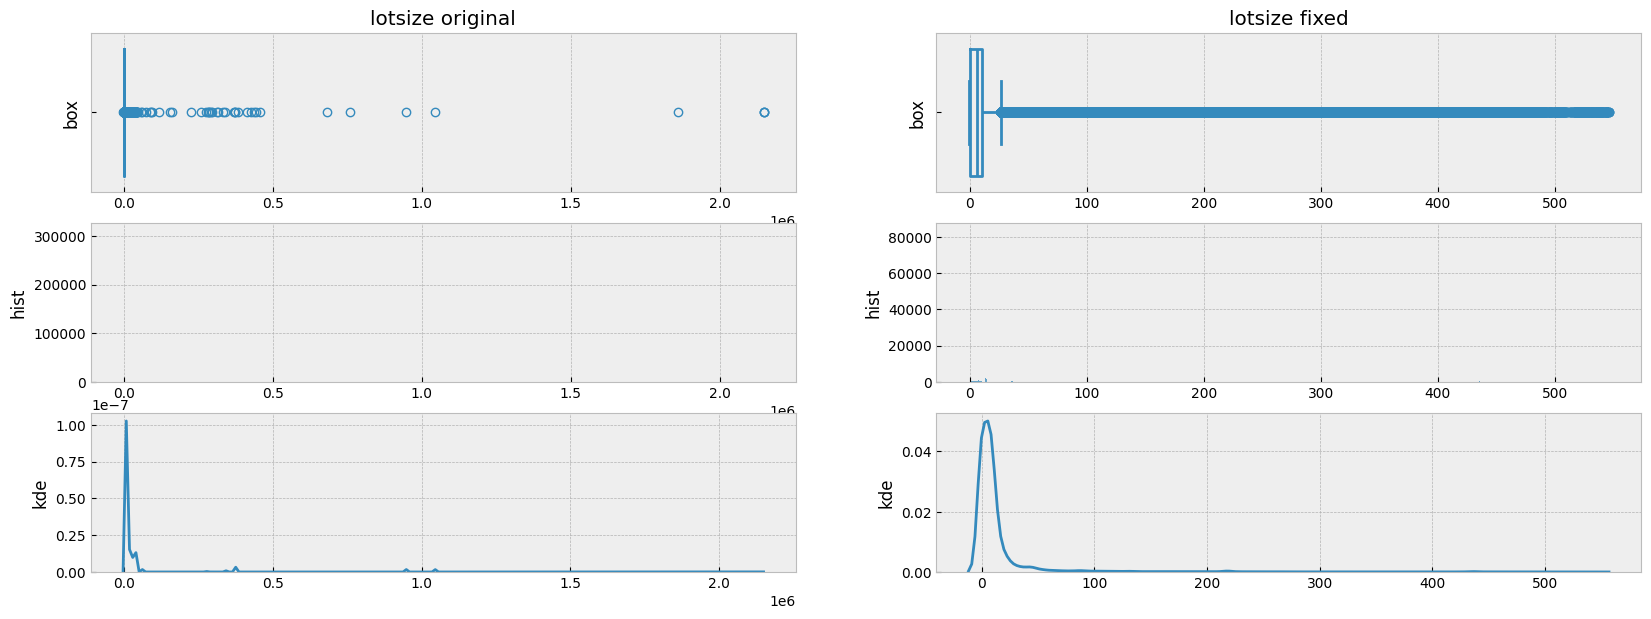

In [15]:
fixed_data = fix_data('lotsize', data=fixed_data)

333564 rows X 112 cols


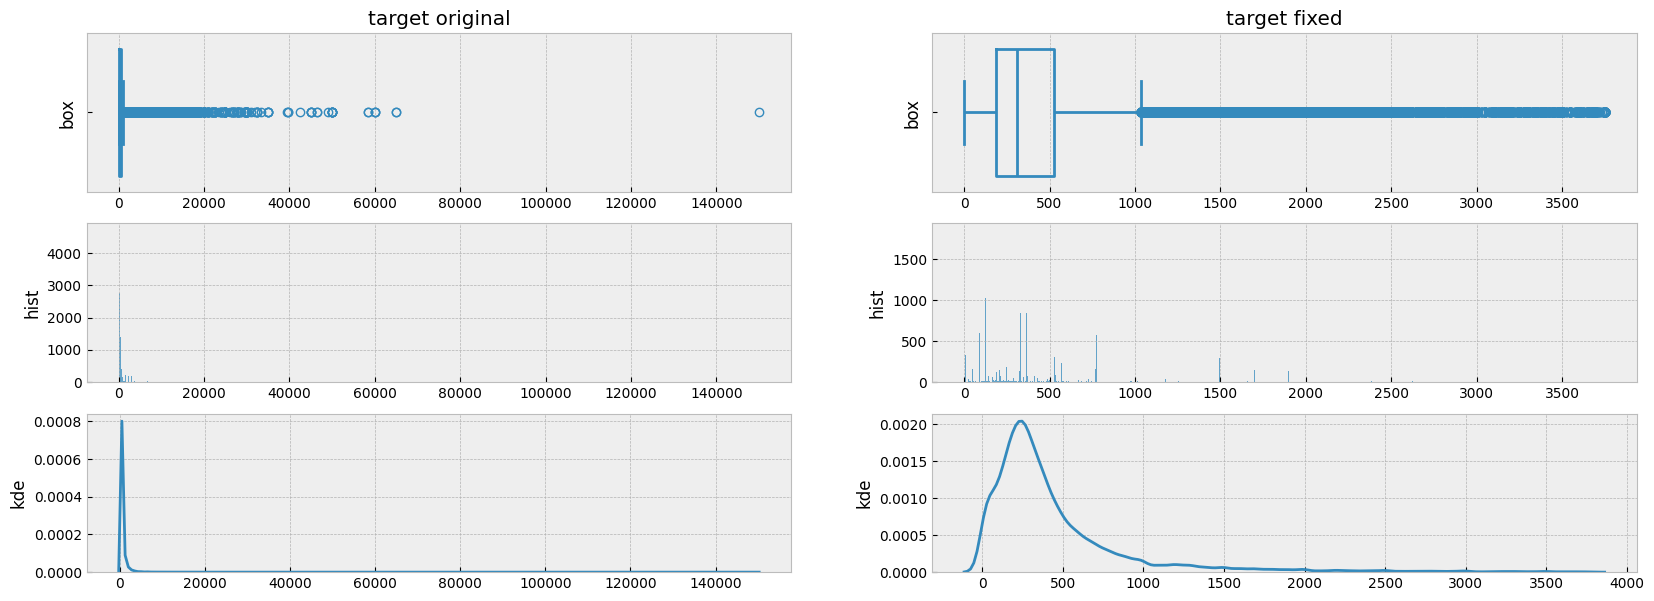

In [16]:
fixed_data = fix_data('target', data=fixed_data)

### Проверка на мультиколлинеарность

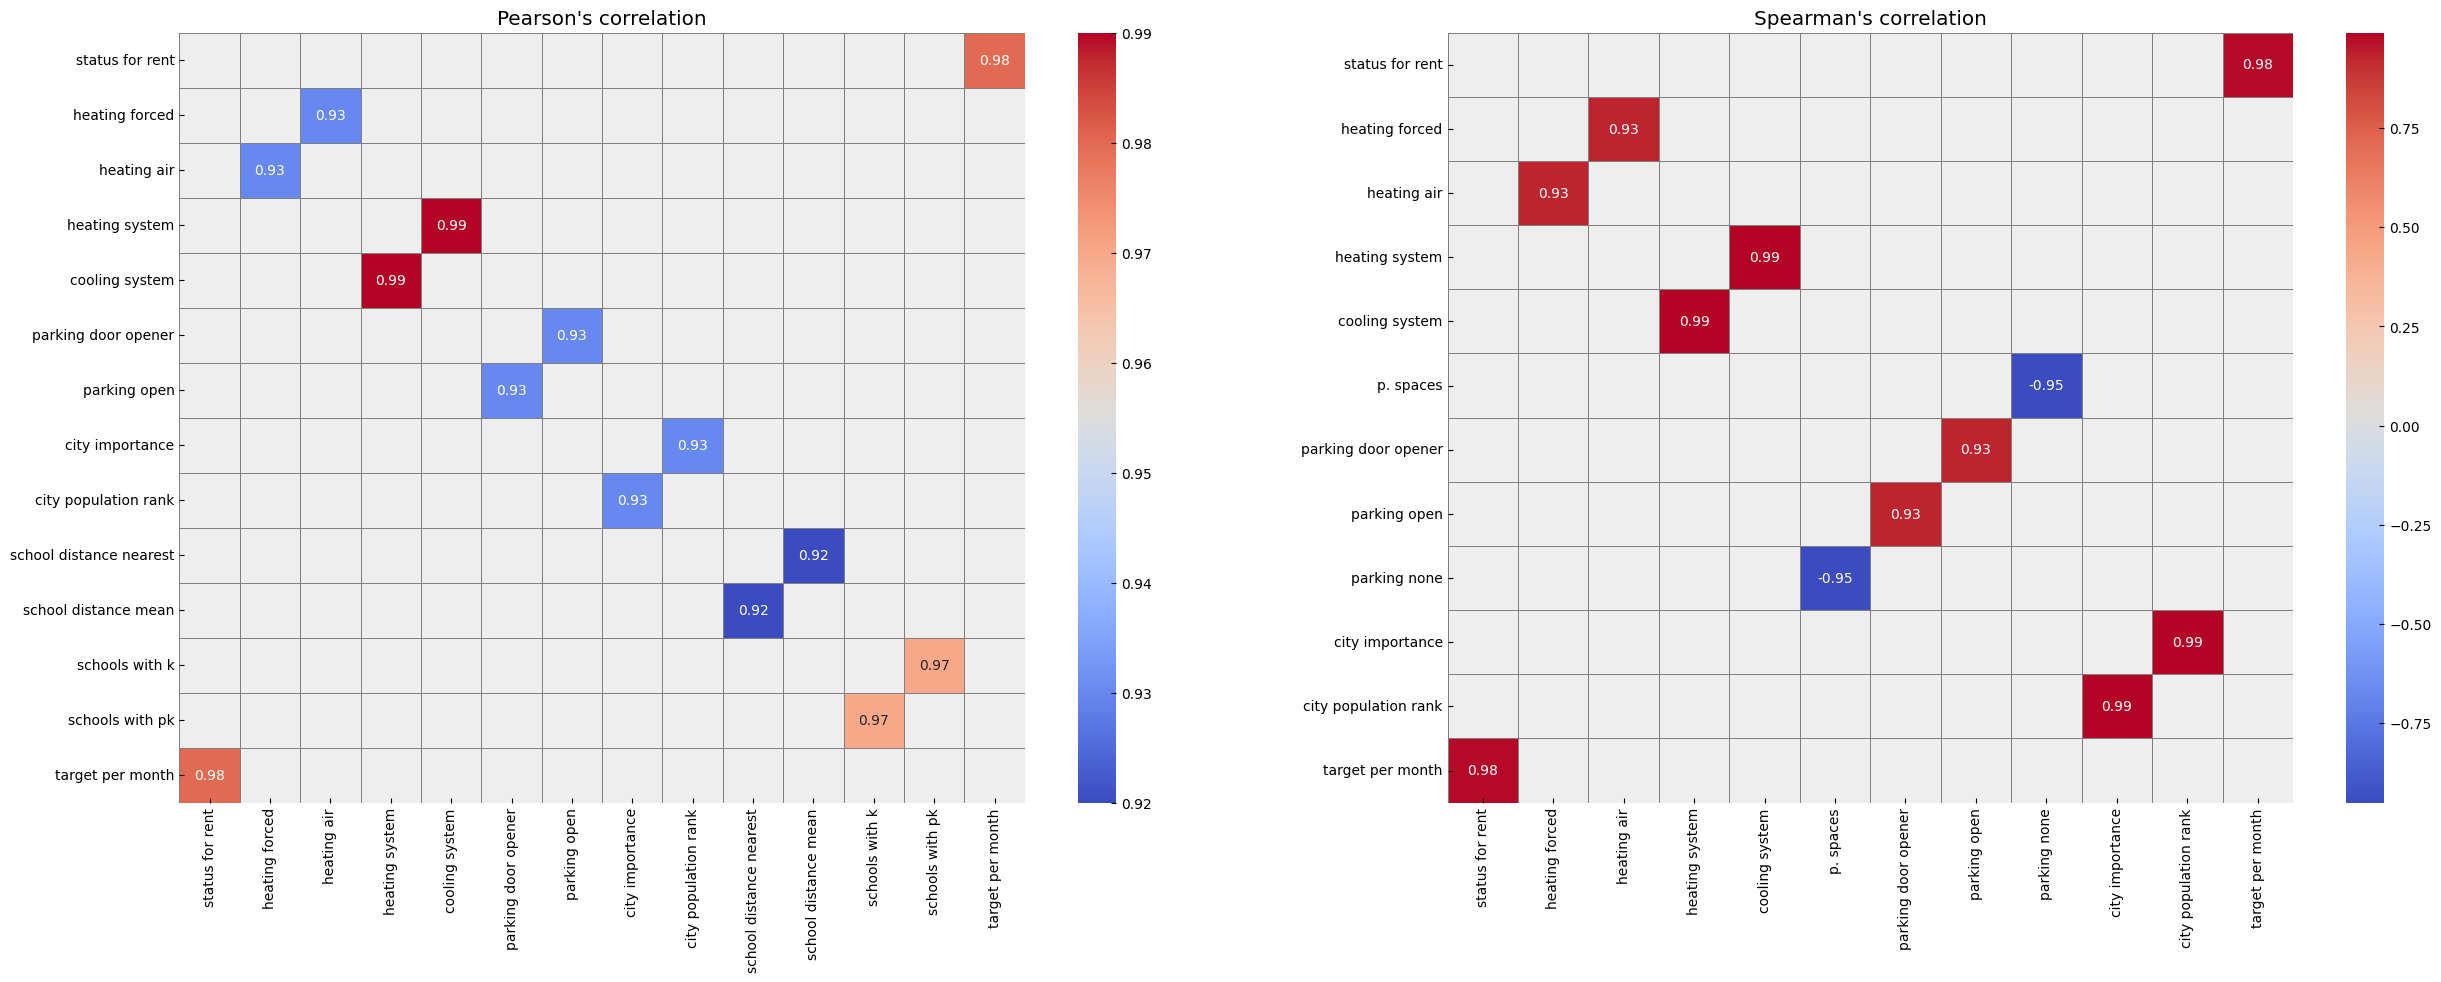

In [17]:
def get_correlations(method, data=fixed_data):
    corr_data = (data.corr(method=method)
                 [data.corr(method=method).abs() > 0.9]
                 .round(2))

    for i in corr_data.index:
        for c in corr_data.columns:
            if i == c:
                corr_data.loc[i, c] = np.nan

    for i, c in zip(corr_data.index, 
                    corr_data.columns):
        if corr_data.loc[i].sum() == 0:
            corr_data.drop(i, axis=0, inplace=True)
        if corr_data.loc[:, c].sum() == 0:
            corr_data.drop(c, axis=1, inplace=True)
            
    return corr_data


fig, ax = plt.subplots(1, 2, figsize=(30, 10))

sns.heatmap(get_correlations('pearson'), 
            annot=True, 
            cmap='coolwarm', 
            linewidths=.5, 
            linecolor='grey', 
            ax=ax[0])
ax[0].set_title("Pearson's correlation")

sns.heatmap(get_correlations('spearman'), 
            annot=True, 
            cmap='coolwarm', 
            linewidths=.5, 
            linecolor='grey', 
            ax=ax[1])
ax[1].set_title("Spearman's correlation")
    
fig.show()

In [18]:
multicollinear_cols = ['status for rent', 'heating forced', 
                       'cooling system',  'parking none', 
                       'parking door opener', 'city importance', 
                       'school distance mean', 'schools with pk']

fixed_data.drop(multicollinear_cols, axis=1, inplace=True)

fixed_data.shape 

(333564, 104)

### Исследования по выборкам

In [19]:
def binary_stattest(data, alpha=0.05):
    bins_list = []

    for col in data.columns:
        if data[col].nunique() == 2:
            bins_list.append(col)
            
    statdata = pd.DataFrame(index=bins_list)
    pv_list = []
    dep_list = []
            
    for col_ in bins_list:
        sample_1 = data[data[col_] == 1]
        sample_0 = data[data[col_] == 0]
        
        _, p = sps.mannwhitneyu(sample_0['target'], 
                                sample_1['target'])
        pv_list.append(p)
        
        if p > alpha:
            dep_list.append(0)
        else:
            dep_list.append(1)
            
    statdata['pvalue'] = pv_list
    statdata['depends'] = dep_list
    
    return statdata

In [20]:
bs_data = binary_stattest(fixed_data)

useless_df = bs_data[bs_data['depends'] == 0]

useless_df

,pvalue,depends
status change,0.231351,0
propertyType stories,0.671973,0
propertyType colonial,0.068914,0
heating gas,0.935965,0
heating heat pump,0.221075,0
heating baseboard,0.507863,0
heating stove,0.967531,0
heating refrigeration,0.951167,0
cooling heat pump,0.209817,0
cooling wall,0.101180,0


In [21]:
fixed_data.drop(useless_df.index, axis=1, inplace=True)

fixed_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 333564 entries, 0 to 333563
Data columns (total 90 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   status for sale             333564 non-null  int64  
 1   status coming soon          333564 non-null  int64  
 2   status new                  333564 non-null  int64  
 3   status foreclosure          333564 non-null  int64  
 4   status pre-foreclosure      333564 non-null  int64  
 5   status pending              333564 non-null  int64  
 6   status auction              333564 non-null  int64  
 7   status active               333564 non-null  int64  
 8   status show                 333564 non-null  int64  
 9   status sold                 333564 non-null  int64  
 10  status under contract       333564 non-null  int64  
 11  status contingent           333564 non-null  int64  
 12  status unknown              333564 non-null  int64  
 13  status other  

### Исследование числовых переменных

In [22]:
num_cols = []

for col in fixed_data.columns:
    if fixed_data[col].nunique() > 2:
        num_cols.append(col)

num_cols.remove('target')

numdata_info = get_data_info(fixed_data[num_cols])

numdata_info

,Nulls,Uniques,Dtypes
baths,0.0,9,int64
beds,0.0,8,int64
sqft area,0.0,6575,float64
property age,0.0,125,int64
property remodeled,0.0,99,int64
p. spaces,0.0,5,int64
lotsize,0.0,16078,float64
zipcode national area,0.0,10,int64
zipcode sectional center,0.0,97,int64
zipcode delivery area,0.0,100,int64


#### *Категориальные*

In [23]:
cat_cols = numdata_info[numdata_info['Uniques'] <= 20].index.tolist()

cat_cols

['baths',
 'beds',
 'p. spaces',
 'zipcode national area',
 'city population rank',
 'school rating nearest',
 'schools with k',
 'schools with preschool',
 'school grades']

In [24]:
def multiple_stattest(data, cols=cat_cols, alpha=0.05):
    statdata = pd.DataFrame(index=cols)
    pv_list = []
    dep_list = []
    
    for c in cols:
        samples = []

        for i in data[c].unique():
            sample = data[data[c] == i]
            samples.append(sample['target'])
            
        _, p = sps.kruskal(*samples)
        
        pv_list.append(p)
        
        
        if p > alpha:
            dep_list.append(0)
        else:
            dep_list.append(1)
            
    statdata['pvalue'] = pv_list
    statdata['depends'] = dep_list
    
            
    return statdata


multiple_stattest(fixed_data)

,pvalue,depends
baths,0.0,1
beds,0.0,1
p. spaces,0.0,1
zipcode national area,0.0,1
city population rank,0.0,1
school rating nearest,0.0,1
schools with k,0.0,1
schools with preschool,0.0,1
school grades,0.0,1


#### *Непрерывные*

In [25]:
for cat in cat_cols:
    num_cols.remove(cat)
    
num_cols, len(num_cols) 

(['sqft area',
  'property age',
  'property remodeled',
  'lotsize',
  'zipcode sectional center',
  'zipcode delivery area',
  'school rating sum',
  'school rating mean',
  'school distance nearest',
  'school distance to best'],
 10)

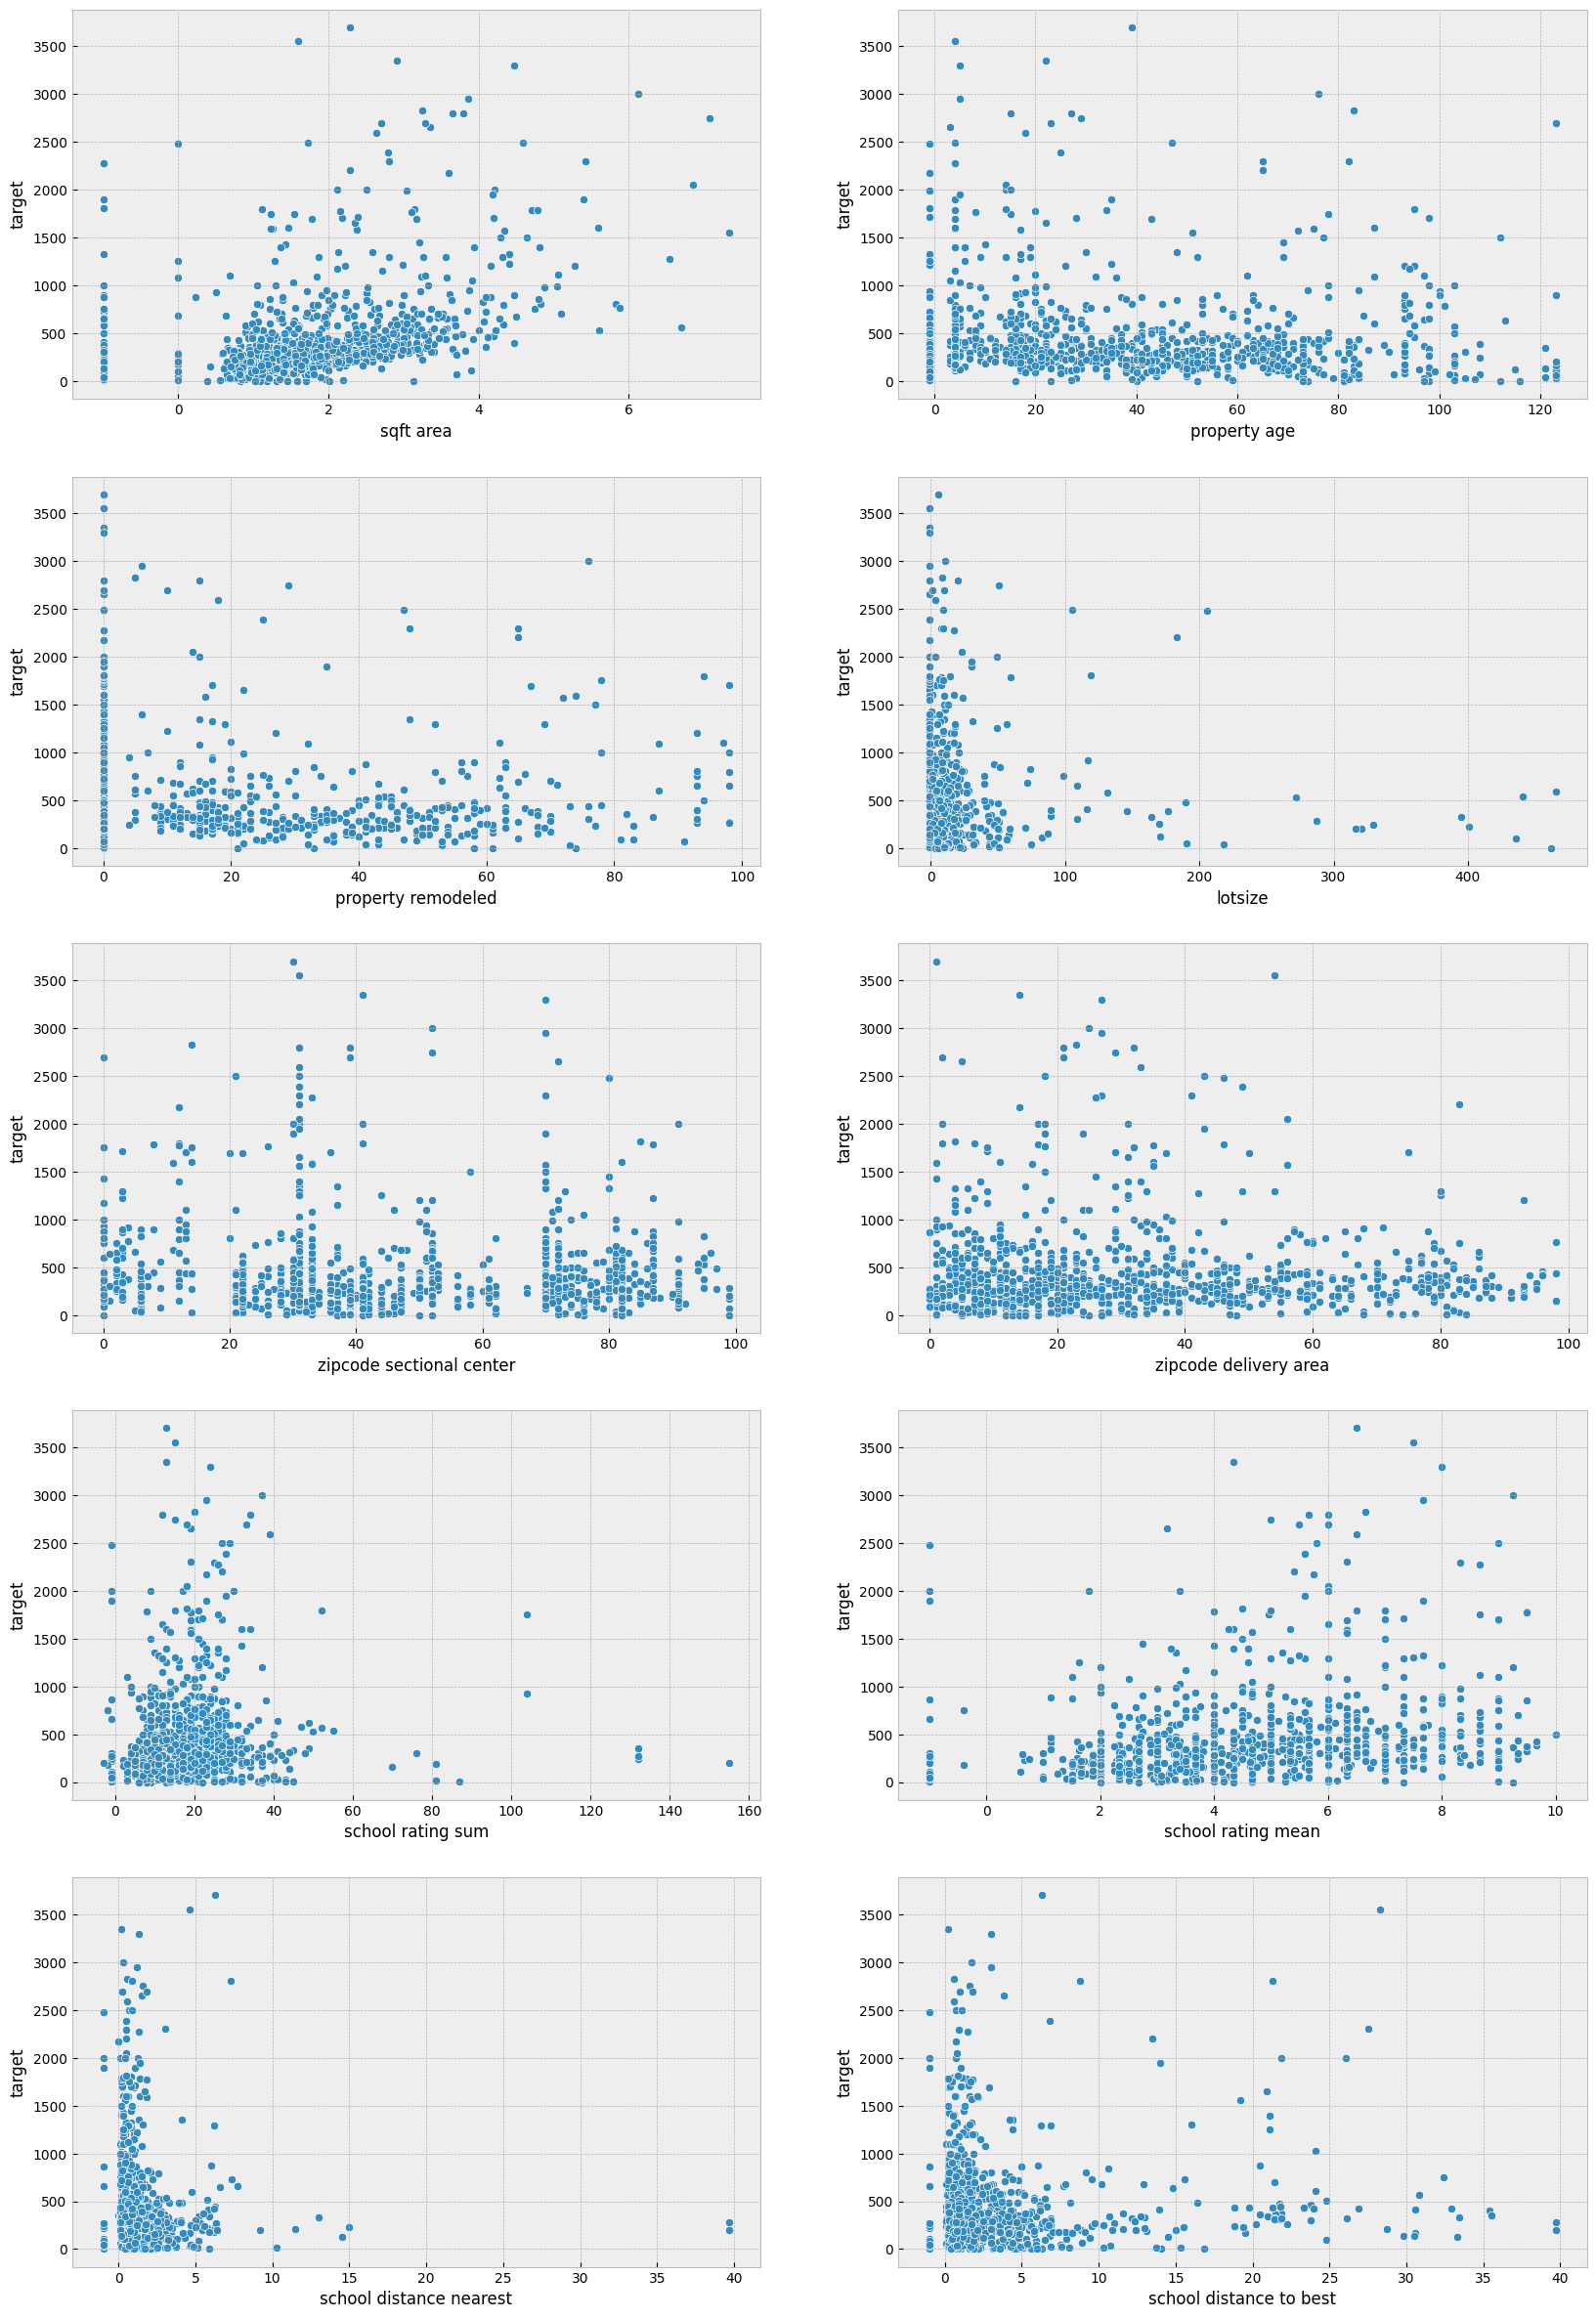

In [26]:
fig, ax = plt.subplots(5, 2, figsize=(20, 30))

for i, col in enumerate(num_cols):
    sample = fixed_data[[col, 'target']].sample(1000, random_state=R)

    if i % 2 == 0:
        ax_place = ax[i//2, 0]
    else:
        ax_place = ax[i//2, 1]
        
    sns.scatterplot(sample, x=col, y='target', ax=ax_place)
    
fig.show()

### Нормализация данных

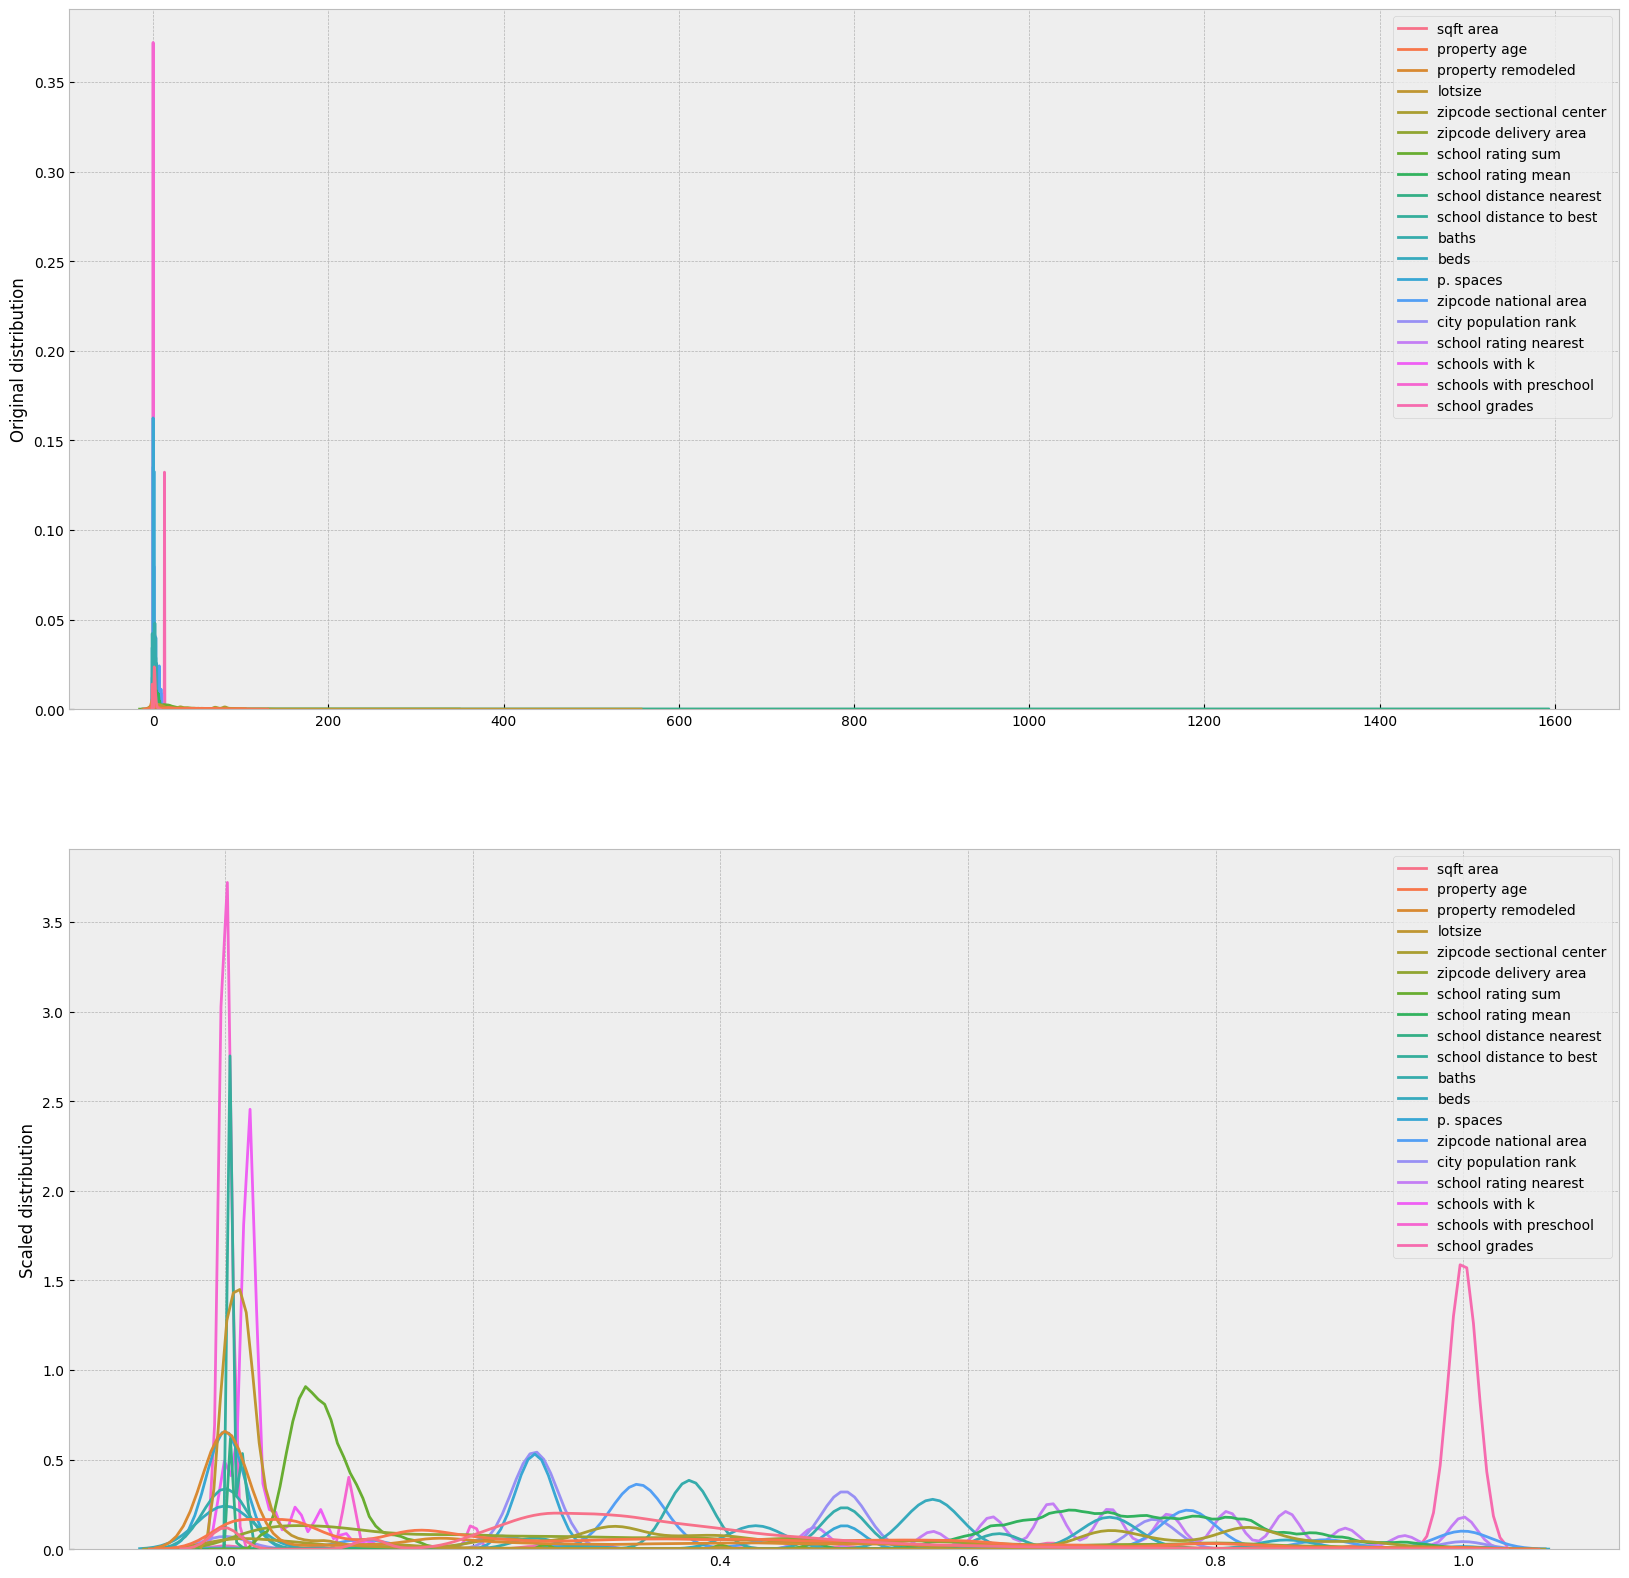

In [27]:
fig, ax = plt.subplots(2, 1, figsize=(20, 20))

num_cols += cat_cols

sns.kdeplot(fixed_data[num_cols], ax=ax[0])
ax[0].set_ylabel('Original distribution')

scaler = pp.MinMaxScaler()
nums_scaled = pd.DataFrame(scaler.fit_transform(fixed_data[num_cols]),
                           columns=scaler.feature_names_in_)

sns.kdeplot(nums_scaled, ax=ax[1])
ax[1].set_ylabel('Scaled distribution')

fig.show()

In [28]:
fixed_data[num_cols] = nums_scaled

fixed_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 333564 entries, 0 to 333563
Data columns (total 90 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   status for sale             333564 non-null  int64  
 1   status coming soon          333564 non-null  int64  
 2   status new                  333564 non-null  int64  
 3   status foreclosure          333564 non-null  int64  
 4   status pre-foreclosure      333564 non-null  int64  
 5   status pending              333564 non-null  int64  
 6   status auction              333564 non-null  int64  
 7   status active               333564 non-null  int64  
 8   status show                 333564 non-null  int64  
 9   status sold                 333564 non-null  int64  
 10  status under contract       333564 non-null  int64  
 11  status contingent           333564 non-null  int64  
 12  status unknown              333564 non-null  int64  
 13  status other  

## **Моделирование**

### Деление данных

In [29]:
X_eval = (fixed_data
          .query('target == 0')
          .drop('target', axis=1))

fixed_data.drop(X_eval.index, axis=0, inplace=True)

X = fixed_data.drop(['target'], axis=1)
y = fixed_data['target']

X_train, X_test, y_train, y_test = ms.train_test_split(X, y, 
                                                       test_size=0.2, 
                                                       random_state=R)


X_train.shape, X_test.shape, y_train.shape, y_test.shape, X_eval.shape

((265513, 89), (66379, 89), (265513,), (66379,), (1672, 89))

### Отбор самых сильных признаков

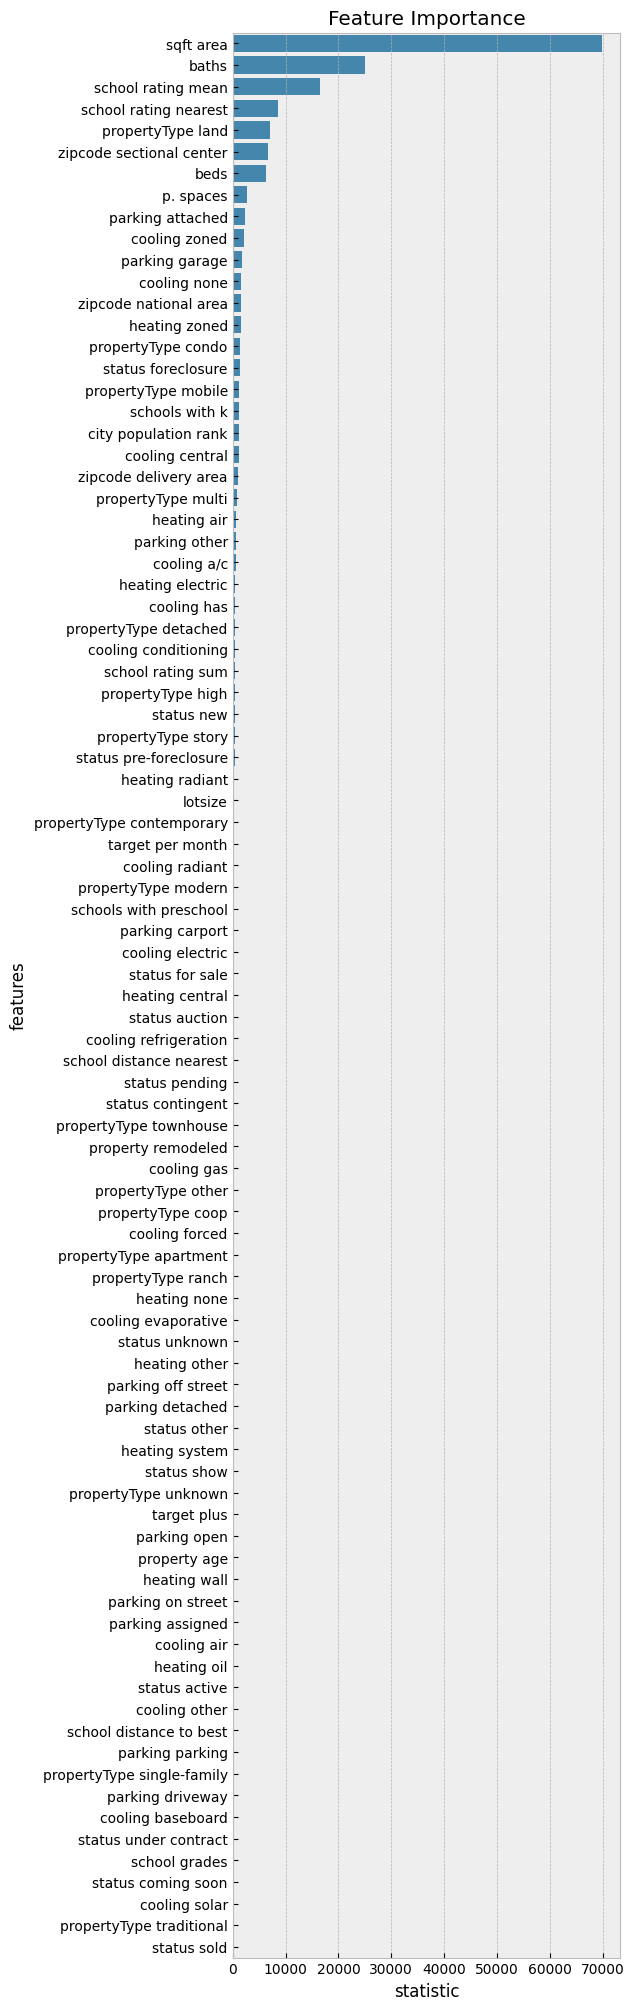

In [30]:
selector = fs.SelectKBest(score_func=fs.f_regression, k=20)
selector.fit(X_train, y_train)

best_feats = selector.get_feature_names_out()

X_train = X_train[best_feats]
X_test = X_test[best_feats]
X_eval = X_eval[best_feats]

selector_scores = pd.DataFrame({'features': selector.feature_names_in_, 
                                'statistic': selector.scores_})

plt.figure(figsize=(5, 25))
sns.barplot(selector_scores.sort_values('statistic', ascending=False), 
            y='features', 
            x='statistic', 
            orient='h').set_title('Feature Importance')

plt.show()

### Подбор модели

In [31]:
def regression_estimate(model, 
                        X_train=X_train, 
                        y_train=y_train, 
                        X_test=X_test, 
                        y_test=y_test):
    metric_dict = {}
    
    model.fit(X_train, y_train)
    
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    
    mae = lambda y_true, y_pred: m.mean_absolute_error(y_true, y_pred).round(2)
    mape = lambda y_true, y_pred: m.mean_absolute_percentage_error(y_true, y_pred).round(2)
    
    metric_dict['MAE_train'] = mae(y_train, train_pred)
    metric_dict['MAE_test'] = mae(y_test, test_pred)
    
    metric_dict['MAPE_train'] = mape(y_train, train_pred).round(2)
    metric_dict['MAPE_test'] = mape(y_test, test_pred).round(2)
    
    metric_dict['R2_train'] = m.r2_score(y_train, train_pred).round(2)
    metric_dict['R2_test'] = m.r2_score(y_test, test_pred).round(2)
    
    metric_dict['Model'] = model
    
    return metric_dict


models = pd.DataFrame(columns=['MAE_train', 'MAE_test', 
                               'MAPE_train', 'MAPE_test', 
                               'R2_train', 'R2_test', 
                               'Model'])

models

,MAE_train,MAE_test,MAPE_train,MAPE_test,R2_train,R2_test,Model


#### *Линейная регрессия (baseline)*

In [32]:
def add_metrics_model(model_name, metrics, data=models, with_params=False):
    if with_params:
        metrics['Model'] = metrics['Model'].best_estimator_
        
    data.loc[model_name] = metrics
    
    return data


lin_reg = regression_estimate(lm.LinearRegression())

add_metrics_model('Linear Regression', lin_reg)

,MAE_train,MAE_test,MAPE_train,MAPE_test,R2_train,R2_test,Model
Linear Regression,242.29,242.52,9.26,2.15,0.34,0.33,LinearRegression()


#### *Полиномиальная регрессия*

In [33]:
polynom = pp.PolynomialFeatures(degree=2, include_bias=False)
polynom.fit(X_train)

X_train_polynom = polynom.transform(X_train)
X_test_polynom = polynom.transform(X_test)

polynom_reg = regression_estimate(lm.LinearRegression(), 
                                  X_train=X_train_polynom, 
                                  X_test=X_test_polynom)

add_metrics_model('Polynomial Regression', polynom_reg)

,MAE_train,MAE_test,MAPE_train,MAPE_test,R2_train,R2_test,Model
Linear Regression,242.29,242.52,9.26,2.15,0.34,0.33,LinearRegression()
Polynomial Regression,193.94,194.59,6.81,1.42,0.51,0.50,LinearRegression()


### Подбор модели с параметрами

#### *Стохастический градиентный спуск*

In [34]:
sgd_reg = regression_estimate(lm.SGDRegressor(random_state=R))

add_metrics_model('SGD', sgd_reg).loc[['SGD']]

,MAE_train,MAE_test,MAPE_train,MAPE_test,R2_train,R2_test,Model
SGD,242.48,242.72,9.26,2.16,0.34,0.33,SGDRegressor(random_state=7)


In [35]:
params = {'max_iter': [1000, 1e4, 1e5], 
          'learning_rate': ['invscaling', 'optimal', 'constant'], 
          'eta0': [0.01, 0.001, 0.0001]}

sgd_rs = ms.RandomizedSearchCV(estimator=lm.SGDRegressor(random_state=R), 
                               param_distributions=params, 
                               random_state=R, cv=5, n_jobs=-1)

sgd_reg = regression_estimate(sgd_rs)

add_metrics_model('SGD', 
                  sgd_reg, 
                  with_params=True)

,MAE_train,MAE_test,MAPE_train,MAPE_test,R2_train,R2_test,Model
Linear Regression,242.29,242.52,9.26,2.15,0.34,0.33,LinearRegression()
Polynomial Regression,193.94,194.59,6.81,1.42,0.51,0.50,LinearRegression()
SGD,242.13,242.35,9.23,2.15,0.34,0.33,"SGDRegressor(eta0=0.001, random_state=7)"


In [36]:
models.loc['SGD', 'Model']

SGDRegressor(eta0=0.001, random_state=7)

#### *L1-регуляризация*

In [37]:
lasso_reg = regression_estimate(lm.Lasso(random_state=R))

add_metrics_model('Lasso', lasso_reg).loc[['Lasso']]

,MAE_train,MAE_test,MAPE_train,MAPE_test,R2_train,R2_test,Model
Lasso,240.79,240.92,9.47,2.07,0.33,0.32,Lasso(random_state=7)


In [38]:
params = {'alpha': np.linspace(1, 30, 30), 
          'max_iter': [1000, 1e4, 1e5], 
          'tol': [0.001, 0.0001, 0.00001]}

lasso_rs = ms.RandomizedSearchCV(estimator=lm.Lasso(random_state=R), 
                                 param_distributions=params, 
                                 random_state=R, cv=5, n_jobs=-1)

lasso_reg = regression_estimate(lasso_rs)

add_metrics_model('Lasso', 
                  lasso_reg, 
                  with_params=True)

,MAE_train,MAE_test,MAPE_train,MAPE_test,R2_train,R2_test,Model
Linear Regression,242.29,242.52,9.26,2.15,0.34,0.33,LinearRegression()
Polynomial Regression,193.94,194.59,6.81,1.42,0.51,0.50,LinearRegression()
SGD,242.13,242.35,9.23,2.15,0.34,0.33,"SGDRegressor(eta0=0.001, random_state=7)"
Lasso,240.79,240.92,9.47,2.07,0.33,0.32,"Lasso(random_state=7, tol=1e-05)"


#### *L2-регуляризация*

In [39]:
ridge_reg = regression_estimate(lm.Ridge(random_state=R))

add_metrics_model('Ridge', ridge_reg).loc[['Ridge']]

,MAE_train,MAE_test,MAPE_train,MAPE_test,R2_train,R2_test,Model
Ridge,242.28,242.51,9.26,2.15,0.34,0.33,Ridge(random_state=7)


In [40]:
ridge_rs = ms.RandomizedSearchCV(estimator=lm.Ridge(random_state=R), 
                                 param_distributions=params, 
                                 random_state=R, cv=5, n_jobs=-1)

ridge_reg = regression_estimate(ridge_rs)

add_metrics_model('Ridge', 
                  ridge_reg, 
                  with_params=True)

,MAE_train,MAE_test,MAPE_train,MAPE_test,R2_train,R2_test,Model
Linear Regression,242.29,242.52,9.26,2.15,0.34,0.33,LinearRegression()
Polynomial Regression,193.94,194.59,6.81,1.42,0.51,0.50,LinearRegression()
SGD,242.13,242.35,9.23,2.15,0.34,0.33,"SGDRegressor(eta0=0.001, random_state=7)"
Lasso,240.79,240.92,9.47,2.07,0.33,0.32,"Lasso(random_state=7, tol=1e-05)"
Ridge,242.28,242.51,9.26,2.15,0.34,0.33,"Ridge(max_iter=1000, random_state=7, tol=1e-05)"


#### *Дерево решений*

In [41]:
tree_reg = regression_estimate(tree.DecisionTreeRegressor(random_state=R))

add_metrics_model('Decision Tree', tree_reg).loc[['Decision Tree']]

,MAE_train,MAE_test,MAPE_train,MAPE_test,R2_train,R2_test,Model
Decision Tree,9.79,151.88,1.9,1.21,0.98,0.52,DecisionTreeRegressor(random_state=7)


In [42]:
params = {'max_depth': [3, 4, 5, 6, 7], 
          'min_samples_split': [1, 2, 3, 4], 
          'min_samples_leaf': [1, 2, 3, 4]}

tree_rs = ms.RandomizedSearchCV(estimator=tree.DecisionTreeRegressor(random_state=R), 
                                param_distributions=params, 
                                random_state=R, cv=5, n_jobs=-1)

tree_reg = regression_estimate(tree_rs)

add_metrics_model('Decision Tree', 
                  tree_reg, 
                  with_params=True)

,MAE_train,MAE_test,MAPE_train,MAPE_test,R2_train,R2_test,Model
Linear Regression,242.29,242.52,9.26,2.15,0.34,0.33,LinearRegression()
Polynomial Regression,193.94,194.59,6.81,1.42,0.51,0.50,LinearRegression()
SGD,242.13,242.35,9.23,2.15,0.34,0.33,"SGDRegressor(eta0=0.001, random_state=7)"
Lasso,240.79,240.92,9.47,2.07,0.33,0.32,"Lasso(random_state=7, tol=1e-05)"
Ridge,242.28,242.51,9.26,2.15,0.34,0.33,"Ridge(max_iter=1000, random_state=7, tol=1e-05)"
Decision Tree,203.73,204.95,11.32,2.37,0.48,0.46,"DecisionTreeRegressor(max_depth=6, min_samples..."


In [43]:
models.loc['Decision Tree', 'Model']

DecisionTreeRegressor(max_depth=6, min_samples_leaf=4, min_samples_split=3,
                      random_state=7)

#### *Случайный лес*

In [44]:
rf_reg = regression_estimate(ens.RandomForestRegressor(random_state=R))

add_metrics_model('Random Forest', rf_reg).loc[['Random Forest']]

,MAE_train,MAE_test,MAPE_train,MAPE_test,R2_train,R2_test,Model
Random Forest,49.96,120.78,4.13,1.1,0.95,0.74,"(DecisionTreeRegressor(max_features=1.0, rando..."


In [45]:
ran_fst = ens.RandomForestRegressor(n_estimators=500, 
                                    max_depth=10,
                                    random_state=R)

rf_reg = regression_estimate(ran_fst)

add_metrics_model('Random Forest', rf_reg)

,MAE_train,MAE_test,MAPE_train,MAPE_test,R2_train,R2_test,Model
Linear Regression,242.29,242.52,9.26,2.15,0.34,0.33,LinearRegression()
Polynomial Regression,193.94,194.59,6.81,1.42,0.51,0.50,LinearRegression()
SGD,242.13,242.35,9.23,2.15,0.34,0.33,"SGDRegressor(eta0=0.001, random_state=7)"
Lasso,240.79,240.92,9.47,2.07,0.33,0.32,"Lasso(random_state=7, tol=1e-05)"
Ridge,242.28,242.51,9.26,2.15,0.34,0.33,"Ridge(max_iter=1000, random_state=7, tol=1e-05)"
Decision Tree,203.73,204.95,11.32,2.37,0.48,0.46,"DecisionTreeRegressor(max_depth=6, min_samples..."
Random Forest,156.19,161.65,9.14,1.60,0.68,0.64,"(DecisionTreeRegressor(max_depth=10, max_featu..."


In [46]:
models.loc['Random Forest', 'Model']

RandomForestRegressor(max_depth=10, n_estimators=500, random_state=7)

### Продвинутые модели

#### *Стекинг*

In [47]:
estimators = [('lr', models.loc['Linear Regression', 'Model']), 
              ('sgd', models.loc['SGD', 'Model'])]

stack = ens.StackingRegressor(estimators=estimators, 
                              final_estimator=models.loc['Random Forest', 'Model'], 
                              cv=5, n_jobs=-1)

stack_reg = regression_estimate(stack)

add_metrics_model('Stacking', stack_reg)

,MAE_train,MAE_test,MAPE_train,MAPE_test,R2_train,R2_test,Model
Linear Regression,242.29,242.52,9.26,2.15,0.34,0.33,LinearRegression()
Polynomial Regression,193.94,194.59,6.81,1.42,0.51,0.50,LinearRegression()
SGD,242.13,242.35,9.23,2.15,0.34,0.33,"SGDRegressor(eta0=0.001, random_state=7)"
Lasso,240.79,240.92,9.47,2.07,0.33,0.32,"Lasso(random_state=7, tol=1e-05)"
Ridge,242.28,242.51,9.26,2.15,0.34,0.33,"Ridge(max_iter=1000, random_state=7, tol=1e-05)"
Decision Tree,203.73,204.95,11.32,2.37,0.48,0.46,"DecisionTreeRegressor(max_depth=6, min_samples..."
Random Forest,156.19,161.65,9.14,1.60,0.68,0.64,"(DecisionTreeRegressor(max_depth=10, max_featu..."
Stacking,218.80,220.35,10.67,2.40,0.41,0.39,"StackingRegressor(cv=5,\n est..."


In [48]:
models.loc['Stacking', 'Model']

StackingRegressor(cv=5,
                  estimators=[('lr', LinearRegression()),
                              ('sgd',
                               SGDRegressor(eta0=0.001, random_state=7))],
                  final_estimator=RandomForestRegressor(max_depth=10,
                                                        n_estimators=500,
                                                        random_state=7),
                  n_jobs=-1)

#### *Градиентный бустинг*

In [49]:
gb_reg = regression_estimate(ens.GradientBoostingRegressor(random_state=R))

add_metrics_model('Gradient Boosting', gb_reg).loc[['Gradient Boosting']]

,MAE_train,MAE_test,MAPE_train,MAPE_test,R2_train,R2_test,Model
Gradient Boosting,174.86,175.8,8.96,1.52,0.58,0.57,([DecisionTreeRegressor(criterion='friedman_ms...


In [50]:
params = {'learning_rate': np.linspace(0.1, 1, 5), 
          'n_estimators': [100, 200, 500], 
          'max_depth': [3, 5, 7, 10]}

gb_rs = ms.RandomizedSearchCV(estimator=ens.GradientBoostingRegressor(random_state=R), 
                              param_distributions=params, 
                              random_state=R, cv=5, n_jobs=-1)

gb_reg = regression_estimate(gb_rs)

add_metrics_model('Gradient Boosting', gb_reg)